In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install sodapy
!pip install -U matplotlib

Create Dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests, json
from sklearn.model_selection import train_test_split
from sodapy import Socrata

In [11]:
first_df=pd.read_csv('Arrests_cleaned.csv')

In [12]:
client = Socrata("data.cityofchicago.org", None)
sec_df = pd.DataFrame()
for i in range(2014,2023):
    results = client.get("ijzp-q8t2", limit=80000, year=i)
    results_df = pd.DataFrame.from_records(results)
    sec_df = [sec_df, results_df[['case_number','ward','district']]]
    sec_df = pd.concat(sec_df)

In [64]:
merged_df_init = pd.merge(first_df, sec_df, on="case_number")
print(len(merged_df_init))
merged_df_init.head(1)

106044


,id,case_number,date_month,date_day,date_year,time,meridiem,race,charge_1_statute,charge_1_description,...,charge_4_statute,charge_4_description,charge_4_type,charge_4_class,CHARGES STATUTE,CHARGES DESCRIPTION,CHARGES TYPE,CHARGES CLASS,ward,district
0,30069116,JE252804,7,16,2021,9:36:00,PM,BLACK,720 ILCS 5.0/12-3.3-A,DOMESTIC BATTERY - AGGRAVATED,...,NaN,NaN,NaN,NaN,720 ILCS 5.0/12-3.3-A | | |,DOMESTIC BATTERY - AGGRAVATED | | |,F | | |,2 | | |,7,004


In [65]:
races = merged_df_init.loc[:, "race"].unique().tolist()
race_dummies = pd.get_dummies(merged_df_init, columns=["race"])
races = ["race_"+r for r in races]
race_dummies = race_dummies[races]
race_dummies

,race_BLACK,race_WHITE HISPANIC,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_UNKNOWN / REFUSED,race_AMER INDIAN / ALASKAN NATIVE
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
106039,1,0,0,0,0,0,0
106040,0,0,1,0,0,0,0
106041,1,0,0,0,0,0,0
106042,0,1,0,0,0,0,0


In [66]:
merged_df = merged_df_init[['ward','district','date_day',
                            'date_year','charge_1_type']]
# merged_df['ward'] = pd.to_numeric(merged_df['ward'])
# merged_df['district'] = pd.to_numeric(merged_df['district'])

merged_df = pd.concat([merged_df, race_dummies], axis=1).dropna()

In [67]:
merged_df

,ward,district,date_day,date_year,charge_1_type,race_BLACK,race_WHITE HISPANIC,race_BLACK HISPANIC,race_WHITE,race_ASIAN / PACIFIC ISLANDER,race_UNKNOWN / REFUSED,race_AMER INDIAN / ALASKAN NATIVE
0,7,004,16,2021,F,1,0,0,0,0,0,0
1,42,001,20,2021,M,1,0,0,0,0,0,0
2,17,007,2,2014,M,1,0,0,0,0,0,0
3,14,008,15,2022,M,0,1,0,0,0,0,0
4,15,008,18,2014,M,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
106039,48,020,7,2022,M,1,0,0,0,0,0,0
106040,22,010,7,2022,F,0,0,1,0,0,0,0
106041,9,005,7,2022,F,1,0,0,0,0,0,0
106042,7,003,7,2022,F,0,1,0,0,0,0,0


In [68]:
x = merged_df[['race_WHITE HISPANIC','race_BLACK','race_BLACK HISPANIC',
               'race_WHITE','race_ASIAN / PACIFIC ISLANDER',
               'race_AMER INDIAN / ALASKAN NATIVE', \
    'race_UNKNOWN / REFUSED','ward','district','date_day','date_year']]
y = merged_df[['charge_1_type']]
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [69]:
merged_df.to_csv('final_dataset.csv')

EDA

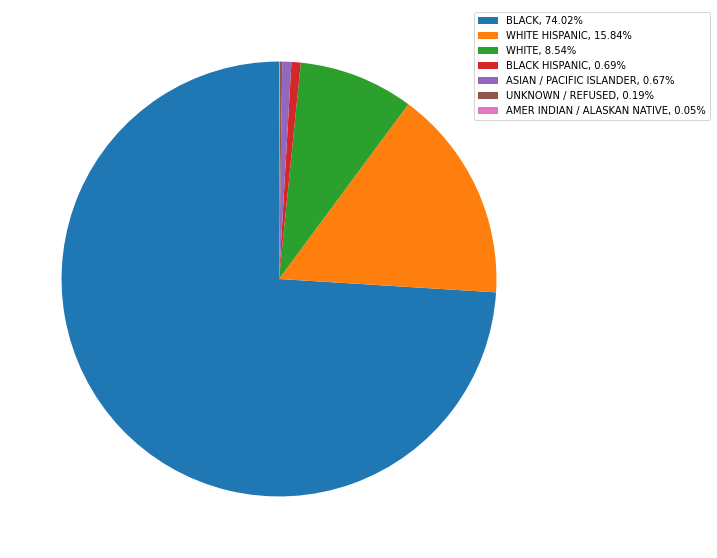

In [19]:
import seaborn as sns

#Pie chart for number of arrests per race

vc=merged_df_init['race'].value_counts()
labels = list(dict(vc).keys())
total=sum(list(dict(vc).values()))
sizes = list(dict(vc).values())/total*100
labels = [f'{l}, {s:0.2f}%' for l, s in zip(labels, sizes)]
plt.figure(figsize = (15,10))
pie = plt.pie(sizes, startangle=90)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)

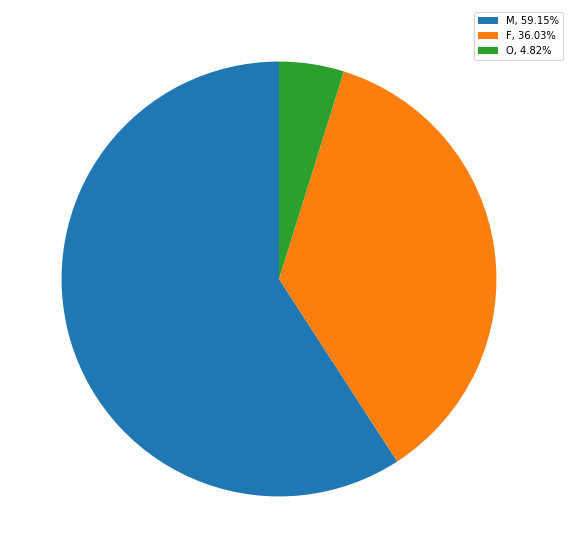

In [20]:
#Pie chart of charge 1 type
vc=merged_df_init['charge_1_type'].value_counts()
labels = list(dict(vc).keys())[:3]
total=sum(list(dict(vc).values()))
sizes = list(dict(vc).values())[:3]/total*100
labels = [f'{l}, {s:0.2f}%' for l, s in zip(labels, sizes)]
plt.figure(figsize = (15,10))
pie = plt.pie(sizes, startangle=90)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)

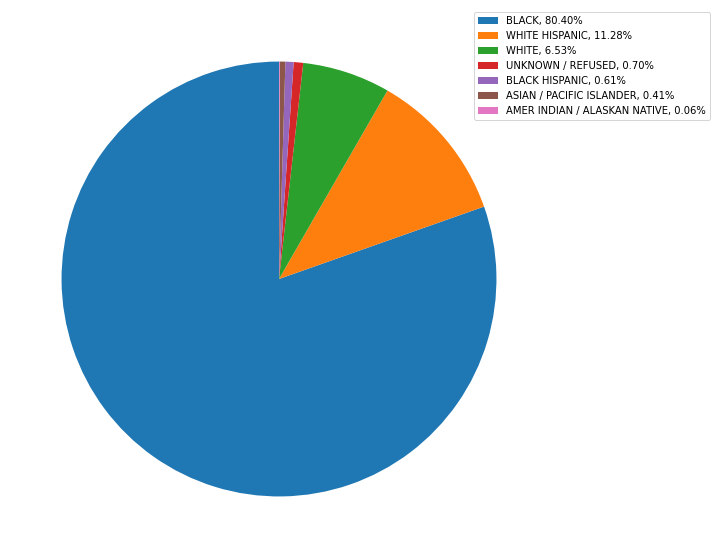

In [21]:
#Chart for number of arrests per charge type per race

df_O=merged_df_init.loc[merged_df_init['charge_1_type']=='O']
vc=df_O['race'].value_counts()
labels = list(dict(vc).keys())
total=sum(list(dict(vc).values()))
sizes = list(dict(vc).values())/total*100
labels = [f'{l}, {s:0.2f}%' for l, s in zip(labels, sizes)]
plt.figure(figsize = (15,10))
pie = plt.pie(sizes, startangle=90)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)

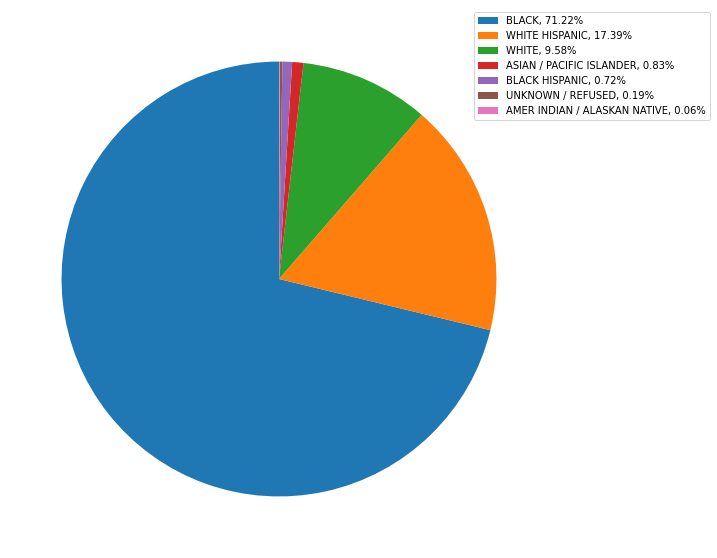

In [22]:
df_M=merged_df_init.loc[merged_df_init['charge_1_type']=='M']
vc=df_M['race'].value_counts()
labels = list(dict(vc).keys())
total=sum(list(dict(vc).values()))
sizes = list(dict(vc).values())/total*100
labels = [f'{l}, {s:0.2f}%' for l, s in zip(labels, sizes)]
plt.figure(figsize = (15,10))
pie = plt.pie(sizes, startangle=90)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)

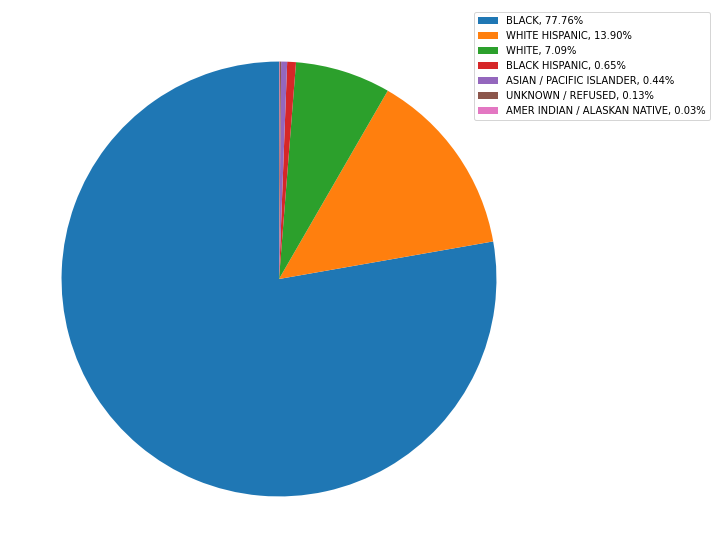

In [23]:
df_M=merged_df_init.loc[merged_df_init['charge_1_type']=='F']
vc=df_M['race'].value_counts()
labels = list(dict(vc).keys())
total=sum(list(dict(vc).values()))
sizes = list(dict(vc).values())/total*100
labels = [f'{l}, {s:0.2f}%' for l, s in zip(labels, sizes)]
plt.figure(figsize = (15,10))
pie = plt.pie(sizes, startangle=90)
plt.legend(bbox_to_anchor=(0.85, 1), loc='upper left', labels=labels)

In [24]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

<AxesSubplot: xlabel='date_year', ylabel='count'>

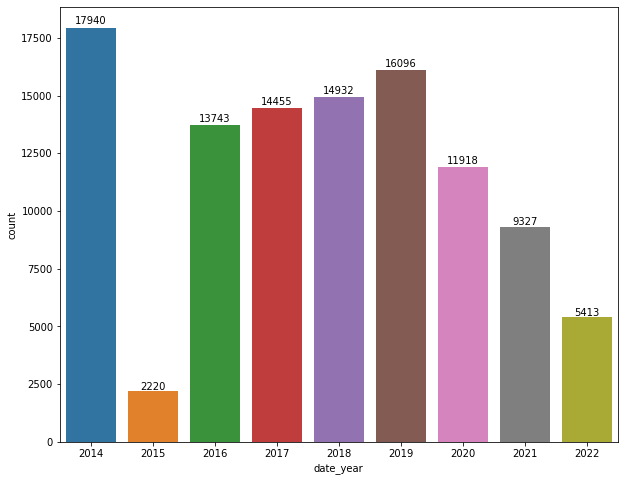

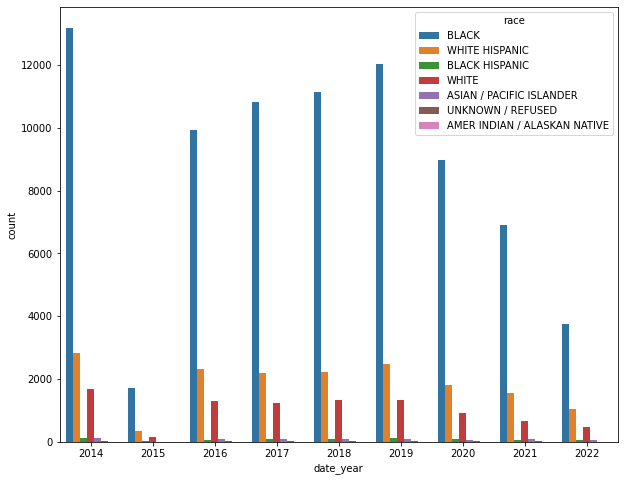

In [25]:
#Chart for number of arrests per year type per race
plt.figure(figsize=(10,8))
p=sns.countplot(x='date_year', data=merged_df_init)
show_values(p)
plt.figure(figsize=(10,8))
sns.countplot(x='date_year', hue='race', data=merged_df_init)

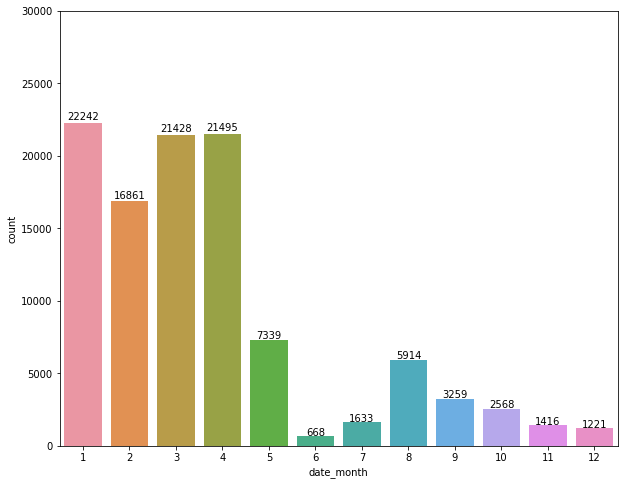

In [26]:
#Total number of arrests per month (1-12)
plt.figure(figsize=(10,8))
p=sns.countplot(x='date_month',data=merged_df_init)
plt.ylim([0, 30000])
show_values(p)

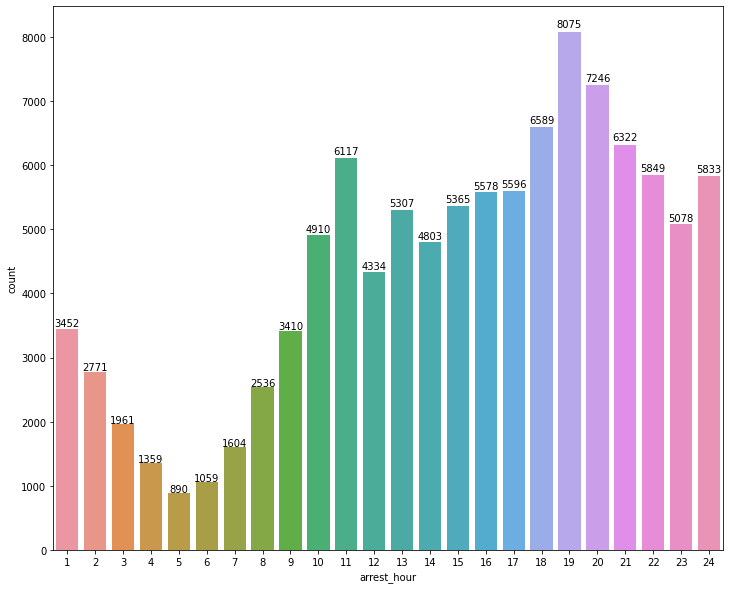

In [27]:
#Total number of arrests per time of day (12am - 11:59pm)
merged_df_init["arrest_hour"]=merged_df_init.apply(lambda x: pd.to_numeric(x['time'].split(':')[0]) if x['meridiem']=='AM' else pd.to_numeric(x['time'].split(':')[0])+12,axis=1)
plt.figure(figsize=(12,10))
p=sns.countplot(x='arrest_hour', data=merged_df_init)
show_values(p)

Global Variables

In [28]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

scalers = [MinMaxScaler(), StandardScaler(), PCA()]

KNN

In [56]:
from  sklearn.neighbors import KNeighborsClassifier

In [78]:
knn = KNeighborsClassifier()
params = {'n_neighbors':[i for i in range(3, 10, 2)],
          'weights':['uniform', 'distance'], 
          # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
          'leaf_size':[i for i in range(20, 40, 5)]}
clf_knn = GridSearchCV(knn, params, cv=5)
clf_knn.fit(x_train,y_train)
print(clf_knn.best_params_)

{'leaf_size': 35, 'n_neighbors': 9, 'weights': 'uniform'}


In [79]:
y_pred = clf_knn.predict(x_test)
print("Multi-class F1 score: ", f1_score(y_test, y_pred, average='macro'))

Multi-class F1 score:  0.44089860405857356


In [80]:
print("Best score:", clf_knn.best_score_)
print("CV score:", clf_knn.cv_results_['mean_test_score'].mean())

Best score: 0.606992588625467
CV score: 0.5861088770433993


In [81]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, clf_knn.best_estimator_)
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_test))

MinMaxScaler() score =  0.6024800792116555
StandardScaler() score =  0.6036588240841152
PCA() score =  0.603988872648404


In [82]:
clf_knn.best_estimator_.fit(x_train,y_train)
y_pred = clf_knn.best_estimator_.predict(x_test)
print("No scaling score = ", accuracy_score(y_pred, y_test))

No scaling score =  0.6058748644443397


Neural Networks

In [70]:
from statistics import mean 
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

In [71]:
net_classifier = MLPClassifier()
net_classifier.fit(x_train,y_train)
classifier_preds = net_classifier.predict(x_test)
score = net_classifier.score(x_test,y_test)
print(score)

0.5892781366401056


In [73]:
scores = []
for scaling in scalers:
    pipe = make_pipeline(scaling, net_classifier)
    pipe.fit(x_train,y_train)
    scores.append(pipe.score(x_test,y_test))

print("MinMaxScore =",scores[0])
print("StandardScaler =",scores[1])
print("PCA =",scores[2])

MinMaxScore = 0.6248762317883917
StandardScaler = 0.6243575840445094
PCA = 0.6331745956905087


In [74]:
parameters = {
    # 'solver': ['lbfgs', 'sgd', 'adam'],
    # 'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    # 'alpha' : [0.001, 0.01,0.0001,0.002,0.003],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [0.001,0.002,0.0011,0.0009],
    'random_state':[0,100,200,300,400],
}

search = GridSearchCV(net_classifier,parameters)
search.fit(x_train,y_train)

best = search.best_estimator_
best_score = best.score(x_test,y_test)
print("Best score:", best_score)
print("CV score:", search.cv_results_['mean_test_score'].mean())
print("Best estimator:", best)

Best score: 0.5892781366401056
CV score: 0.5255745786519285
Best estimator: MLPClassifier(learning_rate_init=0.0009, random_state=200)


In [75]:
scores = []
for scaling in scalers:
    pipe = make_pipeline(scaling, best)
    pipe.fit(x_train,y_train)
    scores.append(pipe.score(x_test,y_test))

print("MinMaxScore =",scores[0])
print("StandardScaler =",scores[1])
print("PCA =",scores[2])

MinMaxScore = 0.6268565231741242
StandardScaler = 0.6271394219435146
PCA = 0.6311943043047763


In [91]:
pipe = make_pipeline(PCA(), best)
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)
print("Multi-class F1 score: ", f1_score(y_test, y_pred, average='macro'))

Multi-class F1 score:  0.32097898281521503


Random Forest

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [58]:
clf_m = RandomForestClassifier(n_estimators = 100,random_state=0)
clf_m.fit(x_train, y_train)
scores_RF = cross_val_score(clf_m, x_train,y_train, cv=5)

In [59]:
parameters = {'max_depth':[i for i in range(6,17,2)],
              'min_samples_leaf':[i for i in range(9, 15)]}
clf_mCV = GridSearchCV(clf_m, parameters, scoring='accuracy', cv=5)
clf_mCV.fit(x_train,y_train)
print("Best estimator:", clf_mCV.best_estimator_)

Best estimator: RandomForestClassifier(max_depth=12, min_samples_leaf=9, random_state=0)


In [60]:
parameters = {'max_features':[i for i in range(4, 9)],
              'min_samples_split':[i for i in range(33,39)]}
clf_mCV = GridSearchCV(clf_mCV.best_estimator_, parameters,cv=5)
clf_mCV.fit(x_train,y_train)

print("Best Estimator:", clf_mCV.best_estimator_)
print("Best score:", clf_mCV.best_score_)
print("CV score:", clf_mCV.cv_results_['mean_test_score'].mean())

Best Estimator: RandomForestClassifier(max_depth=12, max_features=4, min_samples_leaf=9,
                       min_samples_split=38, random_state=0)
Best score: 0.6430870116353828
CV score: 0.642370299278208


In [61]:
# performing predictions on the test dataset
y_pred_m = clf_mCV.best_estimator_.predict(x_test)

# using metrics module for accuracy calculation
print("Accuracy: ", accuracy_score(y_test, y_pred_m))

Accuracy:  0.640058465745674


In [62]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, clf_mCV.best_estimator_)
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_test))

MinMaxScaler() score =  0.6400113159507756
StandardScaler() score =  0.6401056155405724
PCA() score =  0.6403413645150644


In [63]:
print("Multi-class F1 score: ", f1_score(y_test, y_pred_m, average='macro'))

Multi-class F1 score:  0.44342364598448075


Gradient Boosting

In [95]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [96]:
merged_df = merged_df.infer_objects()

x = merged_df[['race_WHITE HISPANIC','race_BLACK','race_BLACK HISPANIC',
               'race_WHITE','race_ASIAN / PACIFIC ISLANDER',
               'race_AMER INDIAN / ALASKAN NATIVE', \
    'race_UNKNOWN / REFUSED','ward','district','date_day','date_year']]

x = x.astype({'district':'int', 'ward':'int'})

m_charge_types = merged_df.loc[:, "charge_1_type"].replace('A', 'M')
m_charge_types = m_charge_types.replace('R', 'O')
m_charge_types = m_charge_types.replace('V', 'O')
multi_class_types = pd.factorize(m_charge_types)
multi_class_types = multi_class_types[0]

x_train, x_test, y_train, y_test = train_test_split(x, multi_class_types, 
                                                    test_size=0.2, 
                                                    random_state=2)

In [30]:
# training
xgb_clf_m = XGBClassifier()
xgb_clf_m.fit(x_train, y_train)

# testing
score_m = xgb_clf_m.score(x_test, y_test)
print("accuracy score: ", score_m)

accuracy score:  0.6382544280355192


In [31]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, XGBClassifier())
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_test))

MinMaxScaler() score =  0.6382544280355192
StandardScaler() score =  0.6382544280355192
PCA() score =  0.6207322285008785


In [ ]:
xgb_params = {"min_child_weight": [i for i in range(1,5)], 
              "max_depth": [i for i in range(3,10)]}
xgb_clf = XGBClassifier()
xgb_clf_cv = GridSearchCV(xgb_clf, scoring='accuracy', 
                          cv=5, param_grid=xgb_params)
xgb_clf_cv.fit(x_train, y_train)


In [34]:
print("best parameters: ", xgb_clf_cv.best_params_)
print("best score:", xgb_clf_cv.best_score_)
print("CV score:", xgb_clf_cv.cv_results_['mean_test_score'].mean())
print("Best Estimator:", xgb_clf_cv.best_estimator_)
print("Accuracy:", xgb_clf_cv.score(x_test, y_test))

best parameters:  {'max_depth': 6, 'min_child_weight': 1}
best score: 0.6410323962813526
CV score: 0.6398901914456119
Best Estimator: XGBClassifier(max_depth=6, objective='multi:softprob')
Accuracy: 0.6432404197730187


In [37]:
y_pred = xgb_clf_cv.predict(x_test)
print("Multi-class F1 score: ", f1_score(y_test, y_pred, average='macro'))

Multi-class F1 score:  0.4417905299748064


In [97]:
# training
light_clf = HistGradientBoostingClassifier()
light_clf.fit(x_train, y_train)

# testing
score_light = light_clf.score(x_test, y_test)
print("accuracy score: ", score_light)

accuracy score:  0.6388325710783158


In [98]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, HistGradientBoostingClassifier())
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_test))

MinMaxScaler() score =  0.6388797208732142
StandardScaler() score =  0.6383139233344335
PCA() score =  0.6351548870762412


In [99]:
hist_params = {"max_iter": [100, 150, 200], "max_leaf_nodes": [31, None], 
               "max_depth": [9, None], "l2_regularization": [0, 0.001, 0.1]}
hist_clf = HistGradientBoostingClassifier()
hist_clf_cv = GridSearchCV(hist_clf, scoring='accuracy', cv=5, 
                           param_grid=hist_params)
hist_clf_cv.fit(x_train, y_train)
print("best parameters: ", hist_clf_cv.best_params_)
print("best score:", hist_clf_cv.best_score_)
print("CV score:", hist_clf_cv.cv_results_['mean_test_score'].mean())
print(hist_clf_cv.score(x_test, y_test))

best parameters:  {'l2_regularization': 0.1, 'max_depth': None, 'max_iter': 200, 'max_leaf_nodes': 31}
best score: 0.6425447520323637
CV score: 0.6370155847658824
0.6392569192324014


In [100]:
y_pred = hist_clf_cv.predict(x_test)
print("Multi-class F1 score: ", f1_score(y_test, y_pred, average='macro'))

Multi-class F1 score:  0.44549039816366554


In [101]:
# Plot
dims = list(range(1, 11))
acc_scores = []
for dim in dims:
    # PCA
    pca_project = PCA(n_components=dim)
    trans_s_data = pca_project.fit_transform(x_train)

    # CV
    hist_params = {'l2_regularization': [0.001], 
                   'max_depth': [None], 'max_iter': [100], 
                   'max_leaf_nodes': [31]}
    hist_clf = HistGradientBoostingClassifier()
    hist_clf_cv = GridSearchCV(hist_clf, scoring='accuracy', 
                               cv=5, param_grid=hist_params)
    hist_clf_cv.fit(trans_s_data, y_train)
    acc_scores.append(hist_clf_cv.best_score_)
    print("dim = ", dim, " accuracy score: ", hist_clf_cv.best_score_)

dim =  1  accuracy score:  0.6317352763765147
dim =  2  accuracy score:  0.6355545381549017
dim =  3  accuracy score:  0.638030025360544
dim =  4  accuracy score:  0.6389730448801457
dim =  5  accuracy score:  0.6401282437569191
dim =  6  accuracy score:  0.6406468927509679
dim =  7  accuracy score:  0.6407294308766335
dim =  8  accuracy score:  0.6412009316043324
dim =  9  accuracy score:  0.6400928914155646
dim =  10  accuracy score:  0.6405761845943733


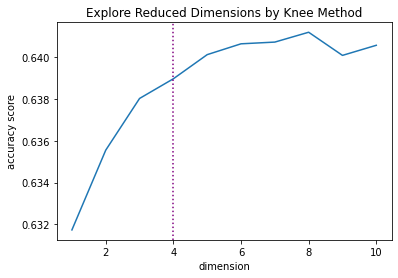

In [102]:
plt.plot(dims, acc_scores)
plt.axvline(x = 4, color = 'purple', label = 'axvline - full height', 
            linestyle=":")
plt.xlabel("dimension")
plt.ylabel("accuracy score")
plt.title("Explore Reduced Dimensions by Knee Method")
plt.show()

Ensemble Model

In [29]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier

In [30]:
y_bool_train = [i == "M" for i in y_train['charge_1_type']]
y_bool_test = [i == "M" for i in y_test['charge_1_type']]

In [31]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
decision_tree_model.fit(x_train, y_bool_train)
y_pred = decision_tree_model.predict(x_test)
cv_results = cross_validate(decision_tree_model, x_train, y_bool_train)
cv_results

{'fit_time': array([0.27965498, 0.25680828, 0.26907229, 0.33667755, 0.30538321]),
 'score_time': array([0.02931714, 0.02734232, 0.0356853 , 0.03655195, 0.03599143]),
 'test_score': array([0.59315141, 0.5895562 , 0.5993399 , 0.59395261, 0.58841212])}

In [32]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy')
params = {'max_depth': [i for i in range(1,21)], 
          'max_leaf_nodes': [i for i in range(20,150,5)]}
clf = GridSearchCV(decision_tree_model, params, scoring='accuracy', cv=5)
clf.fit(x_train, y_bool_train)
print("best params:", clf.best_params_)
print("best score:", clf.best_score_)
print("CV score:", clf.cv_results_['mean_test_score'].mean())

best params: {'max_depth': 10, 'max_leaf_nodes': 105}
best score: 0.6569613135833133
CV score: 0.64778529757916


In [33]:
decision_tree_model = clf.best_estimator_
decision_tree_model.fit(x_train, y_bool_train)
y_pred = decision_tree_model.predict(x_train)
cv_results = cross_validate(decision_tree_model, x_train, y_bool_train)
score = np.mean(cv_results['test_score'])
print("cv result:", score)

cv result: 0.6569731011709836


In [34]:
bg_clf = BaggingClassifier(base_estimator = decision_tree_model)
bg_clf.fit(x_train, y_bool_train)
y_pred = bg_clf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6561365458060258

In [35]:
clf = []
for i in range(10):
    clf.append(bg_clf)
eclf1 = VotingClassifier(estimators=[('clf1', clf[0]), 
                                     ('clf2', clf[1]), 
                                     ('clf3', clf[2]), 
                                     ('clf4', clf[3]), 
                                     ('clf5', clf[4]), 
                                     ('clf6', clf[5]), 
                                     ('clf7', clf[6]), 
                                     ('clf8', clf[7]), 
                                     ('clf9', clf[8]), 
                                     ('clf10', clf[9])], voting='hard')
eclf1 = eclf1.fit(x_train, y_bool_train)
cv_results = cross_validate(eclf1, x_train, y_bool_train)
y_pred = eclf1.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.655570748267245

In [36]:
print("Multi-class F1 score: ", f1_score(y_bool_test, y_pred, average='macro'))

Multi-class F1 score:  0.6055901735613057


In [37]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, bg_clf)
    pipe.fit(x_train,y_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_test))

MinMaxScaler() score =  0.6407185628742516
StandardScaler() score =  0.6395869677966901
PCA() score =  0.6372294780517704


In [38]:
aclf = AdaBoostClassifier()
aclf.fit(x_train,y_bool_train)
y_pred = aclf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6441604979018342

In [39]:
rclf = RandomForestClassifier()
rclf.fit(x_train,y_bool_train)
y_pred = rclf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6210570984016219

In [40]:
eclf = ExtraTreesClassifier()
eclf.fit(x_train,y_bool_train)
y_pred = eclf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6095996982413127

In [41]:
hclf = HistGradientBoostingClassifier()
hclf.fit(x_train,y_bool_train)
y_pred = hclf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6548163515488707

In [42]:
estimators = [('dt', decision_tree_model),('rf',RandomForestClassifier())]
sclf = StackingClassifier(estimators=estimators, \
                          final_estimator=LogisticRegression())
sclf.fit(x_train,y_bool_train)
y_pred = sclf.predict(x_test)
accuracy_score(y_pred, y_bool_test)

0.6551935499080579

In [43]:
params = {'stack_method': ['auto', 'predict_proba', 'decision_function', 
                           'predict'], 'passthrough': [True,False]}
stack_clf = GridSearchCV(sclf, params, scoring='accuracy', cv=5)
stack_clf.fit(x_train, y_bool_train)
print("best params:", stack_clf.best_params_)
print("best score:", stack_clf.best_score_)
print("CV score:", stack_clf.cv_results_['mean_test_score'].mean())

best params: {'passthrough': False, 'stack_method': 'auto'}
best score: 0.6570320404988885
CV score: nan


In [54]:
stackcv = []
for i in stack_clf.cv_results_['mean_test_score']:
  if not np.isnan(i):
    stackcv.append(i)
stackcv = np.array(stackcv)
print("CV score:", stackcv.mean())

CV score: 0.6531616933841219


In [44]:
for index, scaling in enumerate(scalers):
    pipe = make_pipeline(scaling, stack_clf.best_estimator_)
    pipe.fit(x_train,y_bool_train)
    y_pred = pipe.predict(x_test)
    print(scalers[index], "score = ", accuracy_score(y_pred, y_bool_test))

MinMaxScaler() score =  0.6554292988825499
StandardScaler() score =  0.6549106511386675
PCA() score =  0.6502899712386251


In [45]:
y_pred = stack_clf.best_estimator_.predict(x_test)

In [46]:
print("Multi-class F1 score: ", f1_score(y_bool_test, y_pred, average='macro'))

Multi-class F1 score:  0.3707835167769306


Visualizations

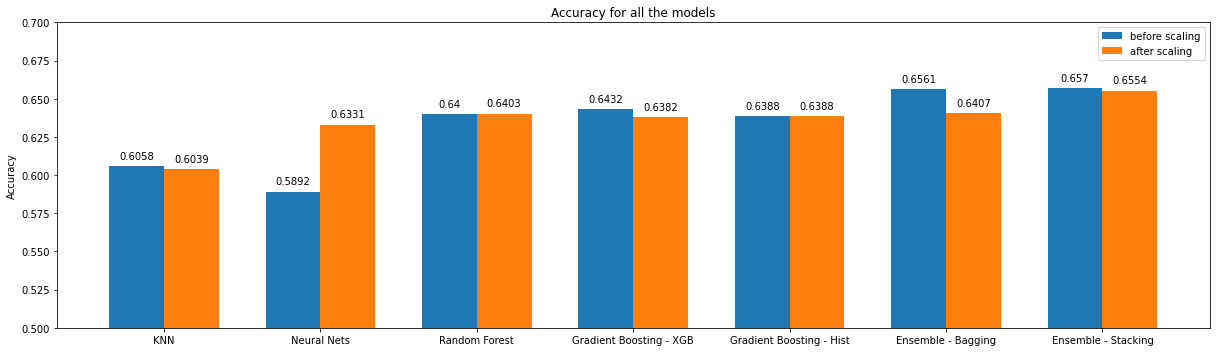

In [103]:
pre_scale = [0.6058, 0.5892, 0.6400, 0.6432, 0.6388, 0.6561, 0.657]
post_scale = [0.6039, 0.6331, 0.6403, 0.6382, 0.6388, 0.6407, 0.6554]
methods = ['KNN','Neural Nets','Random Forest','Gradient Boosting - XGB',
           'Gradient Boosting - Hist','Ensemble - Bagging',
           'Ensemble - Stacking']
x = np.arange(len(methods))
width = 0.35
fig, ax = plt.subplots(figsize = (17, 5))
rects1 = ax.bar(x - width/2, pre_scale, width, label='before scaling')
rects2 = ax.bar(x + width/2, post_scale, width, label='after scaling')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for all the models')
ax.set_xticks(x, methods)
ax.set_ylim([0.5, 0.7])
ax.legend()
ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
fig.tight_layout()
plt.show()
